In [51]:
using PlotlyJS, DataFrames, LinearAlgebra

In [75]:
mutable struct driver
    car_length::Float32
    driver_skill::Float32
    parktime::Int
    policy::Tuple
    driverNo::Int
end

function create_driver(driverNo::Int, policy_distribution::Vector)

    # Car length distribution
    mean_len = 4.25
    len_dev = 0.5

    car_length = round(mean_len .+ len_dev * randn(), digits=1)
    driver_skill = abs(rand(0:0.05:0.8))
    parktime = rand(10:50)
    policy = rand(policy_distribution)
    return driver(car_length, driver_skill, parktime, policy, driverNo)
end

function create_n_drivers(n::Int, policy_distribution::Vector)
    drivers = [create_driver(i, policy_distribution) for i in 1:n]
    return drivers
end

function required_space(driver::driver)
    return driver.car_length + 1 + (driver.car_length * 0.2(1-driver.driver_skill))
end

required_space (generic function with 1 method)

In [160]:
function park!(driver::driver, available_spaces,
     parked_cars::Vector, no_spot)

    req_space = required_space(driver)
    policy = driver.policy
    spot_lens = map(x -> (x[2]-x[1]), available_spaces)
    spot_index = 0
    found_spot = false

    # main policy: determine which spot to park in
    if policy[1] == 1 # take first available spot
        for (i, spot) in enumerate(spot_lens)
            if spot >= req_space
                found_spot = true
                spot_index = i
                break
            end
        end
    elseif policy[1] == 2 # take smallest available spot
        # not super efficient, could sort spot list before but then have to track indices...
        for (i, spot) in enumerate(spot_lens)
            if spot >= req_space
                if found_spot == false
                    found_spot = true
                    spot_index = i
                else # already found spot, check if this one is smaller
                    if spot < spot_lens[spot_index]
                        spot_index = i # select this smaller spot
                    end
                end
            end
        end
    elseif policy[1] == 3 # take largest available spot
        # not super efficient, could sort spot list before but then have to track indices...
        for (i, spot) in enumerate(spot_lens)
            if spot >= req_space
                if found_spot == false
                    found_spot = true
                    spot_index = i
                else # already found spot, check if this one is larger
                    if spot > spot_lens[spot_index]
                        spot_index = i # select this larger spot
                    end
                end
            end
        end 
    end

    if  found_spot
        free_space = (req_space - driver.car_length)
        rear, front, dNo_right = available_spaces[spot_index]

        # sub-policy: how to park in selected space
        if policy[2] == 1 # pull up to front
            car_start = rear + 0.2free_space #driver pulls very close to front car
            car_end = car_start + driver.car_length # most open space in rear
        elseif policy[2] == 2 # back up to rear
            car_end = front - 0.2free_space #driver backs up close to rear car
            car_start = car_end - driver.car_length
        elseif policy[2] == 3 # park in middle
            car_start = rear + 0.5free_space
            car_end = car_start + driver.car_length
        end

        # update available spaces in place, drack driver positions
        splice!(available_spaces, spot_index, [(rear, car_start, driver.driverNo), (car_end, front, dNo_right)])
        # add driver to list of parked cars in place
        push!(parked_cars, (car_start, car_end, driver.parktime, driver.driverNo))
    else
        no_spot[] +=1
    end

    # nothing is returned as the park! function only updates available_spaces, parked_cars
    return Nothing
end


park! (generic function with 1 method)

In [161]:
function park_sim(drivers::Vector{driver}, curb_length; verbose::Bool = false)

    tick = 0
    no_spot = Ref(0)
    available_spaces = [(0.0, curb_length, 0)] #rear, front, driver to right (0 if none)
    parked_cars = []

    while true
        tick += 1

        # end simulation once all of drivers have searched for a spot
        if isempty(drivers)
            break 
        end

        driver = pop!(drivers) # extract last driver from list
        
        # simulate driver searching parking
        park!(driver, available_spaces, parked_cars, no_spot)

        # update parktime for each of the parked vehicles
        if !isempty(parked_cars)
            parked_cars = map(x -> (x[1], x[2], x[3] - 1, x[4]), parked_cars)
        end

        # reduce time left in spot, if zero, remove driver from parked cars list and reallocate their spot to available_spaces
        for (i, (car_start, car_end, parktime, driverNo)) in enumerate(parked_cars)
            if parktime <= 0
                deleteat!(parked_cars, i)
                parking_space = findfirst(x -> x[3] == driverNo, available_spaces)
                now_available = (available_spaces[parking_space][1], available_spaces[parking_space+1][2], available_spaces[parking_space+1][3])
                splice!(available_spaces, parking_space:parking_space+1, [now_available])
            end
        end
    end

    residual_space = curb_length - sum(map(x -> (x[2] - x[1]), parked_cars))
    
    if verbose
        println("There were ", round(residual_space, digits = 3), " meters of unused curb space. (",
                round(100(residual_space/curb_length), digits = 3), "%)")
        println(no_spot[], " drivers were unable to find a spot.")
    end

    park_results = Dict("parked_cars" => parked_cars,
                        "residual_space" => residual_space,
                        "no_spot" => no_spot)

    return(park_results)
end

park_sim (generic function with 1 method)

In [162]:
policies = [(1,1), (1,2), (1,3), (2,1), (2,2), (2,3), (3,1), (3,2), (3,3)]

9-element Vector{Tuple{Int64, Int64}}:
 (1, 1)
 (1, 2)
 (1, 3)
 (2, 1)
 (2, 2)
 (2, 3)
 (3, 1)
 (3, 2)
 (3, 3)

In [185]:
function compare_policies(policies, curb_len, number_of_drivers::Int, iterations::Int)

    residual_space = []
    sad_drivers = []
    policy_names = []

    for policy in policies

        trial_space = 0
        trial_drivers = 0

        for i in 1:iterations
            drivers = create_n_drivers(number_of_drivers, [policy])
            simulation = park_sim(drivers, curb_len)
            trial_space += simulation["residual_space"]
            trial_drivers += simulation["no_spot"][]
        end

        average_space = trial_space/iterations
        average_drivers = trial_drivers/iterations
        policy_name = "Policy " * string(policy[1]) * "." * string(policy[2])

        push!(residual_space, (average_space/curb_len)*100)
        push!(sad_drivers, (average_drivers/number_of_drivers)*100)
        push!(policy_names, policy_name)
    end

    results = DataFrame(space = residual_space, no_spot = sad_drivers, pol = policy_names)
    return results
end

compare_policies (generic function with 1 method)

In [199]:
function plot_comparison(comparison::DataFrame; title::String = "Simulation Results")
    
    p1 = plot(bar(comparison, x=:pol, y=:no_spot, name="No Spot (%)"))
    p2 = plot(bar(comparison, x=:pol, y=:space, name="Residual Space (%)"))
    p = [p1 p2]
    relayout!(p, title_text=title)
    return p
end

plot_comparison (generic function with 2 methods)

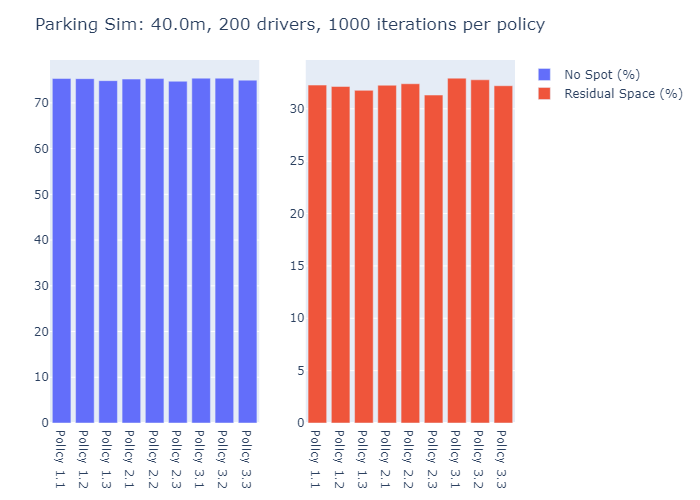

In [207]:
curb = 40.0
no_drivers = 200
iterations = 1000
title = "Parking Sim: " * string(curb) * "m, " * string(no_drivers) * " drivers, " * string(iterations) * " iterations per policy"
comparison = compare_policies(policies, curb, no_drivers, iterations)
plot_comparison(comparison, title=title)

In [215]:
# Interactive plot with PlotlyJS backend
function plot_cars(policies, curb_length, number_of_drivers::Int; title::String="End state with varying policies")

    plot_list = []

    for policy in policies
        drivers = create_n_drivers(number_of_drivers, [policy])
        simulation = park_sim(drivers, curb_length)

        starts = map(x -> x[1], simulation["parked_cars"])
        ends = map(x -> x[2], simulation["parked_cars"])
        driverNo = map(x -> x[4], simulation["parked_cars"])

        x = [starts; ends]
        y = ones(2*size(x)[1])
        traces = [scatter(x=[0, curb_length], y=[0.1, 0.1], mode="lines", line=attr(width=100, color="black", label=""))]
        
        for i in eachindex(starts)
            trace = scatter(x=[starts[i],ends[i]], y=[0.2,0.2], text="Driver $(driverNo[i])", mode="lines", line=attr(width=30), label="")
            push!(traces, trace)
        end

        policy_name = "Policy " * string(policy[1]) * "." * string(policy[2])
        layout = Layout(title=policy_name, showlegend=false, xaxis=attr(ticks="outside", tick0=0, dtick=10),
                        yaxis=attr(showticklabels=false, range=[0, 0.3]), label=false)
        
        p = plot(traces, layout)
        push!(plot_list, p)
    end

    plots = [plot_list[1] plot_list[2] plot_list[3];
     plot_list[4] plot_list[5] plot_list[6];
     plot_list[7] plot_list[8] plot_list[9]]

    relayout!(plots, title_text=title, showlegend=false)
    return plots
end

plot_cars (generic function with 2 methods)

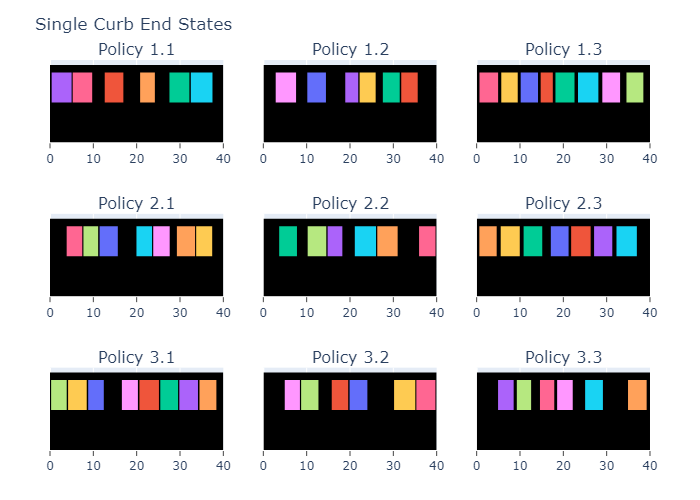

In [216]:
plot_cars(policies, 40.0, 200, title = "Single Curb End States")

In [68]:
function check_overlap!(result::Dict)
    sorted_cars = sort(result["parked_cars"], by = x -> x[1])
    last_rear = 0
    for (i, (front, rear, _, _)) in enumerate(sorted_cars)
        if i != 1
            (front - last_rear < 0) && error("Overlap at index ", i-1, " and ", i, "." )  
        end
        last_rear = rear
    end
    print("No overlap!")
    return Nothing
end


check_overlap! (generic function with 1 method)

In [69]:
check_overlap!(result);

No overlap!